**프로젝트 요구사항**

- `웹 크롤링`
    - requests 패키지를 사용하여 웹 서버에 GET 요청을 보내고, 응답 객체를 해석할 수 있다.
    - BeautifulSoup 함수를 활용하여 웹 문서를 구성 요소(element)를 탐색하고 필요한 값을 추출한다.
    - find 메소드와 find_all 메소드를 구분하여 적용할 수 있다.
    - 태그 이름과 태그를 구성하는 속성 정보를 이용할 수 있다.
    - 문자열 포매팅을 활용하여 추출하려는 웹 페이지의 URL을 조합할 수 있다.
- `한국어 형태소 분석`
    - 인터넷에서 네이버 영화 리뷰 데이터셋을 찾아서, 판다스 데이터프레임으로 변환하여 준비한다.
    - 한국어 형태소 분석기를 지원하는 KoNLPy를 설치하고 활용할 수 있다.
    - 문장을 단어 단위로 분할하고, 분할된 단어들을 다시 문장으로 결합할 수 있다.
    - 문장을 벡터로 표현하는 TF-IDF 벡터화 기법을 이해하고 적용할 수 있다. (sklearn 패키지의 TfidfVectorizer 활용)
- `머신러닝 활용`
    - LDA (LatentDirichletAllocation) 기법을 적용하여 토픽 모델링을 처리해 보고, 결과를 해석할 수 있다.
    - pyLDAvis 시각화 라이브러리를 설치하고,  LDA 토픽 모델링 결과를 해석할 수 있다.
    - 머신러닝 분류 알고리즘인 로지스틱 회귀(Logistic Regression)를 적용하여, 리뷰의 긍정 또는 부정 감성을 예측할 수 있다.
    - 웹 크롤링을 통해서 수집한 네이버 영화 리뷰 텍스트를 분류 모델에 입력하여 긍정인지 부정인지 감성을 분류할 수 있다.

## part 1. 네이버 영화 리뷰 크롤링 실습 가이드

> 네이버 영화 리뷰 페이지에 접속하기

In [ ]:
#request 불러오기
import requests 
import json

url =  "https://movie.naver.com/movie/bi/mi/review.naver?code=81888" 

resp = requests.get(url)
resp #-> 200 

resp.text[400:500] #->서버 응답중 소스코드 부분 출력 

> BeautifulSoup 으로 HTML 해석하기

* bs, request로 웹 파싱 참고 : https://library.gabia.com/contents/9239/ 

In [ ]:
 #필요한 라이브러리 import
from bs4 import BeautifulSoup as bs


soup = bs(resp.text, 'html.parser') 
print(soup) #-> 파싱한 내용을 담은 객체 자료형 확인 -> head -> title -> 제목잇음

> 1) 영화제목 파싱

In [ ]:
title_tag = soup.find(name='title')
print(title_tag) #-><title>탑건: 매버릭 : 네이버 영화</title> 

title_text = title_tag.get_text()
print(title_text) #-> 탑건: 매버릭 : 네이버 영화

> 2. 리뷰 갯수 파싱

In [ ]:
# 리뷰 개수 확인 
# span 태그의 class속성값을 활용해 리뷰 갯수 포함 요소 tag 찾기 
count_tag = soup.find(name ='span', attrs={'class' : 'cnt'})
print("count tag : {}".format(count_tag))

# count_tag 요소에서 em 태그 부분 찾기 
count_tag =count_tag.find(name ='em')
print('em tag : {}'.format(count_tag))

# 텍스트 부분만 추출
count_text = count_tag.get_text()
print("text : {}".format(count_text)) #-> 108 

#count_tag = count_tag.find(name='em')
#print('em 태그 : '.format(count_tag))

> 3. 리뷰 목록

In [ ]:
# <ul class = "rvw_list_area">

review_list_tag = soup.find(name ='ul', attrs={'class': 'rvw_list_area'})
print("review list tag : {}".format(len(review_list_tag)))

review_list_tags = review_list_tag.find_all(name='li') #-> 실질적으로 내용이 있는 리뷰 
print(len(review_list_tags))

print(review_list_tags[0])

In [ ]:
# 첫 번쨰 요소에서 리뷰 제목(rli_title), 사용자(rli_uid), 내용 데이터(rli.content) 추출
#리뷰 제목
review_title = review_list_tags[0].find_all('a')[0].get_text()
print('review title : {}'.format(review_title))
#사용자
review_uid = review_list_tags[0].find_all('a')[1].get_text()
print('review uid : {}'.format(review_uid))
#내용데이터
review_content = review_list_tags[0].find_all('a')[2].get_text()
print('review content : {}'.format(review_content))

In [ ]:
# 각 리뷰 페이지로 연결한 nid값 을 포함하는 jS 코드 추출
review_nid = review_list_tags[0].find('a').get('onclick')
review_nid 

# js 코드에서 7자리 숫자 추출 (정규식 re 모듈 활용)
import re
review_nid = re.findall('\d{7}', review_nid)[0]
review_nid #-> 4808692

In [ ]:
#URL 조합하기 
# https://movie.naver.com/movie/bi/mi/reviewread.naver?nid=4808692&code=81888&order=#tab nid값이 존재!
review_url = f"https://movie.naver.com/movie/bi/mi/reviewread.naver?nid={review_nid}&code=81888&order=#tab"

print(f"상세 리뷰 페이지 : {review_url}")


In [ ]:
#위의 형식에 맞춰 반복문으로 10개 리뷰를 조회해서 리뷰 제목(rli.title) 및 사용자(rli.uid), 상세 페이지 url 값 추출하기

title_list = list()
uid_list = list()
url_list = list()

for li_tag in review_list_tags:
    
    review_title = li_tag.find_all('a')[0].get_text() #a태그에 있는 요소 중 text로 이루어진 파일 가지고오기 
    title_list.append(review_title)
    
    review_uid = li_tag.find_all('a')[1].get_text()
    uid_list.append(review_uid)
    
    review_url_nid =  re.findall('\d{7}', li_tag.find('a').get('onclick'))[0]
    
    review_url = f"https://movie.naver.com/movie/bi/mi/reviewread.naver?nid={review_url_nid}&code=81888&order=#tab"
    
    url_list.append(review_url)
    
print(f'title_li : {title_list}')
print(f'uid_li : {uid_list}')
print(f'url_li : {url_list}')

> 4 리뷰 상세 페이지 탐색

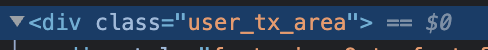

In [ ]:
# 리뷰 상세페이지의 HTML 소스 ㅋ코드를 가지고와서 파싱
resp_text = requests.get(url_list[0], headers = { 'User-agent' : 'agent'}) #-> 200
soup_text = bs(resp_text.text, 'html.parser') #-> html 소스코드 파싱 완료
# 리뷰 본문 텍스트 추출
review_text_tag = soup_text.find(name='div', attrs={'class':'user_tx_area'})
review_text = review_text_tag.get_text() #텍스트 부분만 추출 
print(review_text)

In [ ]:
text_list = [] 
for url in url_list:
    
    resp_text = requests.get(url, headers={'User-agent' : 'agent'})
    soup_text = bs(resp_text.text, 'html.parser') #> html 소스 코드 파싱 완료 
    
    # 본문 텍스트 추출
    review_text_tag = soup_text.find(name ='div', attrs={'class': 'user_tx_area'})
    review_text = review_text_tag.get_text()
    text_list.append(review_text)

    print(review_text[0:200])

> 6. 판다스 데이터프레임으로 정리 및 CSV 파일 저장

In [ ]:
#딕셔너리 형식으로 항목별 리스트를 원소로 추가
dict_data = {
    'title' : title_list,
    'user' : uid_list,
    'review' : text_list
}
#DF 로 변환
import pandas as pd 
df_data =pd.DataFrame(dict_data)

df_data

In [ ]:
#csv파일로 저장
df_data.to_csv('./data/naver_review_topgun.csv')

## part 2. 자연어 처리

1. 네이버 영화 리뷰 데이터셋을 활용하여, 자연어 모델링을 위한 형태소 분석 등 전처리 기법을 학습합니다.

2. 전처리된 자연어 데이터를 벡터화하는 TF-IDF 기법을 이해합니다.

3. 벡터화된 데이터를 활용하여 토픽 모델링과 감성분석 모델링을 실습해봅니다.

> 라이브러리 불러오기

In [ ]:
import pandas as pd 
import numpy as np 

import os, re
from tqdm import tqdm 

#경고 문구 미표시
import warnings
warnings.filterwarnings('ignore') #무시 

#한글폰트 지정
import matplotlib.pyplot as plt 
plt.rc('font', family='NanumBarunGothic')

> 네이버 영화 리뷰 데이터 다운 

In [ ]:
# 다운 받을 폴더 준비
DATA_DIR = './data'
os.makedirs(DATA_DIR, exist_ok= True)


> #### (로컬에서 실습할 경우) 파이토치 설치: conda install pytorch==1.12.0 -c pytorch 
> #### (로컬에서 실습할 경우) torchtext 설치: conda install -c pytorch torchtext 

In [ ]:
import torchtext

In [ ]:
torchtext.utils.download_from_url(url='https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', 
                                  path=os.path.join(DATA_DIR, 'review.txt'))

In [ ]:
data = pd.read_csv('./data/review.txt', sep = '\t') #txt파일 DF 읽어오기
data.head()
data.info()

> 한글 형태소 분석

> -1) KoNLPy 설치
* https://konlpy.org/ko/latest/install/ 로컬설치

In [ ]:
# 긍정 리뷰를 하나 선택
sample_text = data['document'][149978]
print(type(sample_text)) #-> str
print(sample_text)

In [ ]:
# 트위터 형태소 분석기(Okt)를 활용
from konlpy.utils import pprint
from konlpy.tag import Okt


okt = Okt()
print(okt)

#에러뜨면 이거 참고 https://muten.tistory.com/13 15버전으로 해야됨 

In [ ]:
# (단어 ,품사) 추출
tokens = okt.pos(sample_text)
pprint(tokens)

In [ ]:
#단어만 추출  morphs 
tokens = okt.morphs(sample_text)
pprint(tokens)

In [ ]:
# 명사만 추출 okt.nouns(data)
tokens = okt.nouns(sample_text)
pprint(tokens)

> 3.텍스트 전처리

In [ ]:
#okt 분석 도구 중 명사를 추출하는 함수를 사용해 각 리뷰문장에서 명사를 토큰화시킴 -> 이 떄, 두 글자 이하의 단어를 분석대상에서 제외

#누락 데이터 제거
review_data = data['document'].dropna().values
type(review_data)#-> 누락제거 및 공백 제거, array

#학습 속도 고려해 1000개 샘플을 선택해 추출
review_data =review_data[:1000]

#배열 크기
print(f"배열 크기 : {review_data.shape}") #-> 1000

#첫번쨰 데이터
print(f"첫번쨰 데이터 : {review_data[1]}")


In [ ]:
# 세글자 이상 명사를 사용 (두글자 이하는 제거)
clean_review_data = list()

for review in tqdm(review_data):
    tokens = okt.nouns(review)
    cleaned_tokens = list()
    for word in tokens:
        if len(word) > 3:
            cleaned_tokens.append(word)
        else:
            pass
    cleaned_review = ' '.join(tokens)
    clean_review_data.append(cleaned_review)
    
print(len(clean_review_data))
print(clean_review_data[0:20]) 

> 4) TF-IDF 벡터로 표현 

LDA, 로지스틱 회귀 등 머신러닝의 입력값은 수치형태로 표현된 매트릭스입니다. 머신러닝 모델을 활용하기 위해 이 프로젝트에서는 TF-IDF의 형태로 텍스트 문서를 수치화 합니다.

In [ ]:
# pip install scikit-learn #사이킷런 설치 

# 사이킷런 패키지 활용 
from sklearn.feature_extraction.text import TfidfVectorizer


# TF-IDF 변환기 객체 생성
tfid = TfidfVectorizer()

# TF-IDF 변환기에 데이터를 입력해 반환 
review_tfid = tfid.fit_transform(clean_review_data)

# 배열 크기
print(review_tfid.shape) #-> 1000, 2040(=단어 사전 ㅋ기) 

# 첫번쨰데이터
print(review_tfid[0])


In [ ]:
# 단어 사전 확인 (딕셔너리 형태)
vocab = tfid.vocabulary_

# 단어 사전 크기
print(len(vocab)) #-> 2040

#단어 사전 출력 (앞에서 5개 단어만 출력)
print(
    {k : v for i, (k, v) in enumerate(vocab.items()) if i < 5} #5개 단어만 출력
) # k : word , v : index


In [ ]:
# 단어들의 사전 인덱스를 이용해 원래 단어 검색하는 매핑 딛ㄱ셔너리
index_to_word = {v:k for k, v in vocab.items()}

print(
    {k : v for i, (k, v) in enumerate(index_to_word.items()) if i < 5}
)  #-> k : index , v : word

In [ ]:
# 첫번쨰 리뷰를 구성하는 단어의 사전 인덱스이용해 원래 단어 복원 (순서 복원 x)

original_text = ' '.join([index_to_word[word_idx] for word_idx in review_tfid[0].indices])

original_text

> ### Topic Modeling

문서는 여러 종류의 단어들의 집합체로 구성, 문서를 구성하는 단어들의 확률분포를 활용해 문서의 토픽을 파악할 수 있음!

> #### 1) LDA (LatentDirichletAllocation)**

LDA 토픽 모델링을 이용하여, 문서로부터 두 종류의 토픽을 추출합니다. 문서의 감성(긍정, 부정) 형태로 토픽이 추출되는지, 아니면 다른 종류의 토픽이 추출되는지 분석하세요.

In [ ]:
# 사이킷런 패키지 활용
from sklearn.decomposition import LatentDirichletAllocation

# LDA 모델링 객체를 생성 (토픽 갯수를 2로 설정: 긍정/부정)
lda = LatentDirichletAllocation(2)  

# TF-IDF 벡터를 입력하여 모델 학습 
lda.fit(review_tfid)

In [ ]:
# 토픽 모델링 결과를 담고 있는 배열의 형태 : (2개의 토픽, 2157개의 단어)
print(lda.components_.shape) #-> 2개(긍정/부정) 2040개 단어 

In [ ]:
# 2040개 단어중 토픽 별로 가장 중요도 높은 단어 10개씩 출력

for idx, topic in enumerate(lda.components_):
    print(f"토픽 유형 {idx+1} : ",[(index_to_word[i], topic[i].round(3)) for i in topic.argsort()[:-30:-1]])

> #### 1) pyLDAvis 시각화

pyLDAvis 패키지를 활용하여, LDA 토픽 모델링 경과를 시각화 합니다.

In [ ]:
# pip install pyldavis 설치
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
visualization = pyLDAvis.sklearn.prepare(lda, review_tfid, tfid)
pyLDAvis.display(visualization)

> ## Sentimental Analysis (감성 분석)

감성 분석은 문장(텍스트)에 드러나는 사람들의 생각이나 느낌, 성향과 같이 주관적인 감성을 분석하는 자연어 처리 기법입니다. 머신러닝 분류 모델을 활용하여 문장이 갖는 긍정 또는 부정의 감성을 예측하세요.

> ### 1. 머신러닝 알고리즘을 활용하여, 긍정/부정 감성을 분류

In [ ]:
labels = data['label'].iloc[:1000].values 
print(labels.shape)
print(labels[:5])

In [ ]:
# 사이킷런 패키지 활용
from sklearn.linear_model import LogisticRegression

# 로지스틱 분류 모델링 객체 생성
lr = LogisticRegression()

lr.fit(review_tfid, labels)

In [ ]:
# 첫 번째 샘플을 이용하여 모델 예측
pred = lr.predict(review_tfid[0])
print(pred)

> ### 2. Part 1에서 수집한 리뷰를 긍정, 부정으로 감성 분류 예측

In [ ]:
# 폴더에 csv 파일 업로드 (./data/naver_review_topgun.csv)

# df로 읽어기
test = pd.read_csv('./data/naver_review_topgun.csv')

test.head()

In [ ]:
# 첫번쨰리뷰 선택
test_sample = test['review'][0]
test_sample

In [ ]:
#한글뺴고 다 제거 
test_sample = re.sub(r"[^가-힣]","", test_sample)
test_sample

In [54]:
# 세글자 이상의 명사만 가지고 오기
tokens = okt.nouns(test_sample)
cleaned_tokens = list()

for word in tokens:
    if len(word) > 3:
        cleaned_tokens.append(word)
    else:
        pass
cleaned_review = ' '.join(tokens)
        
cleaned_review   

'탑건 버릭 감독 코 스키 출연 톰크루즈 제니퍼 코넬 리 마일 텔러 개봉 미국 평점 리뷰 보기 이영화 주전 결혼식 준비 이제 탑건 매 버릭 후기 정식 개봉 전 평론 단 리뷰 매우 기대 고등학생 때 톰크루즈 및 다른 헐리우드 배우 들 필 싹 년대 끝 자락 로서 년대 영화 영 지라 탑건 본적 탑건 매 버릭 이틀 전 년 개봉 탑건 탑건 안 무방 오프닝 탑건 오마주 제대로 탑건 후 속편 감상 무조건 탑건 보고 탑건 매 버릭 감상 강력 추천 탑건 청춘영화 자체 모두 가동 톰크루즈 외모 년대 탑건 이유 톰크루즈 미모 때문 정도 당시 분위기 탑건 각본 다른 영화 비교 해크 게다 게 년대 특 유의 청춘영화 분위기 영화 동영상 탑건 매 버릭 메인 예고편 하늘 스펙 타 액션 톰크루즈 항공 액션 블록버스터 탑건 매 버릭 월일 극장 고공 레이스 합류 탑건 매 버릭 한국 은월 일로 개봉 대신 톰크루즈 마일 텔러 글렌 포웰 내한 프로모션 돌기 다 해외 프로모션 개념 개념 장본인 이바 톰크루즈 다 심지어 년대 당시 한국 프로모션 상국 가가 불구 톰크루즈 처음 영화 프로모션 한국 방문 하니 톰 아저씨 닉값 년 탑건 매 버릭 현시 반영 영화 년대 인터넷 컴퓨터 아날로그 세대 디지털 시대 살 지금 사람 더 이상 전투기 조종 최첨단 무인전투기 사용 시작 탑건 매 버릭 와 관련 주제 대화 조종사 곧 멸종 대목 세대 서시대 상황 것 볼수 조금 다년 탑건 왜 성공 가 상황 탑건 매 버릭 이서구 폭발 인기 이유 알것 요즘 영화사 프렌 차이 히어로 물 위주 영화관 향 발길 년대 당시 청년 분 이제 중년 노년 탑건 속편 보기 위해 다시 영화관 해외 리뷰 탑건 매 버릭 합류 제니퍼 코넬 리 톰크루즈 러브 라인 배우 본체 둘 다대 초 중반 후반 임 불구 년 전탑 건의 청춘 무드 그대로 영화 위 플래쉬 주연 마일 텔러 가조 코신 스키 감독 다시 한번 호흡 마일 텔러 조 코신 스키 감독 전작 온 더 브레이브 막내 소방관 출연 마일 텔러 니콜라스홀트 와글 렌 포웰 을제 구스 아들 루스 터 역할 캐스팅 마일 텔러 